In [42]:
import DSGRN
from DSGRN import *

import sys
sys.setrecursionlimit(10**8)
sys.path.insert(0,'/home/elizabeth/Desktop/GIT/dsgrn_acdc/src')

from PhenotypeGraphFun import flatten, find_a_path
from GradientFun import get_gradlist_strict, get_gradient_graph_parallel, remove_dict_value
from CondensationGraph_iter import condensation_graph_optimized
from PhenotypeGraphviz import PhenotypeGraphviz

from copy import deepcopy

In [2]:
database = Database("/home/elizabeth/Desktop/ACDC/ACDC_FullconnE2.db") #change to your file location
network = Network("/home/elizabeth/Desktop/ACDC/ACDC_FullconnE2") #change to your file location
pg = ParameterGraph(network)
pg.size()

313600

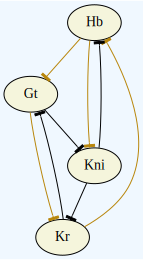

In [3]:
DrawGraph(network)

In [4]:
Kni_list = {0: ['00'], 1:['40'], 2:['44','50','C0' ], 3: ['54','C4','D0'], 4: ['55','D4','CC','F0'], 5: ['D5','DC','F4'], 6: ['DD','F5','FC'], 7: ['FD'], 8:['FF']}
Hb_list = {0:['FF'], 1: ['FD'], 2: ['DD','F5','FC'], 3: ['D5','DC','F4'], 4: ['55','D4','CC','F0'], 5: ['54','C4','D0'], 6:['44','50','C0' ], 7:['40'], 8: ['00']}

In [7]:
%%time
gradlist = get_gradlist_strict(database, Hb_list, Kni_list)

CPU times: user 49.4 s, sys: 0 ns, total: 49.4 s
Wall time: 49.4 s


In [21]:
%%time
grad_graph = get_gradient_graph_parallel(database, gradlist, 4, Hb_list, Kni_list)

CPU times: user 854 ms, sys: 96.3 ms, total: 951 ms
Wall time: 10.1 s


In [11]:
len(grad_graph)

115294

In [12]:
FP_list = ['FP { 0, 2, 0, 0 }', 'FP { 1, 2, 0, 0 }', 'FP { 2, 2, 0, 0 }','FP { 2, 0, 0, 0 }', 'FP { 2, 1, 0, 0 }', 'FP { 2, 2, 0, 0 }','FP { 2, 0, 0, 0 }', 'FP { 2, 0, 1, 0 }', 'FP { 2, 0, 2, 0 }','FP { 0, 0, 2, 0 }', 'FP { 1, 0, 2, 0 }', 'FP { 2, 0, 2, 0 }','FP { 0, 0, 2, 0 }', 'FP { 0, 0, 2, 1 }', 'FP { 0, 0, 2, 2 }','FP { 0, 0, 0, 2 }', 'FP { 0, 0, 1, 2 }', 'FP { 0, 0, 2, 2 }','FP { 0, 0, 0, 2 }', 'FP { 0, 1, 0, 2 }', 'FP { 0, 2, 0, 2 }','FP { 0, 2, 0, 0 }', 'FP { 0, 2, 0, 1 }', 'FP { 0, 2, 0, 2 }']

In [22]:
c = database.conn.cursor()
pg = DSGRN.ParameterGraph(database.network)

redu_grad_graph = deepcopy(grad_graph)
del_list = []

for node in grad_graph:
    p = node[2]
    MGI_result = c.execute('select MorseGraphIndex from Signatures where ParameterIndex is ' + str(p))
    MGI = MGI_result.fetchone()[0]
    FP_result = c.execute('select Label from MorseGraphAnnotations where MorseGraphIndex is ' + str(MGI))
    FP = FP_result.fetchone()[0]
    #print(p,FP)
    if FP not in FP_list:
        del redu_grad_graph[node]
        del_list.append(node)
len(del_list)

74056

In [23]:
len(redu_grad_graph)

41238

In [24]:
%%time
final_grad_graph = remove_dict_value(redu_grad_graph, del_list)

CPU times: user 10min 26s, sys: 864 ms, total: 10min 27s
Wall time: 10min 26s


In [26]:
len(final_grad_graph)

41238

In [29]:
%%time
cond, red_gradlist, scc = condensation_graph_optimized(final_grad_graph)

CPU times: user 12.4 s, sys: 19.9 ms, total: 12.4 s
Wall time: 12.4 s


In [30]:
not_safe = [] #deletes all nodes that are isolated
for i in cond:
    if cond[i]==[]:
        if i not in flatten(list(cond.values())): 
            not_safe.append(i)
for n in not_safe:
    del cond[n]                
len(not_safe) 

467

In [31]:
len(cond)

861

In [36]:
PhenotypeGraphviz(database, network, cond, 'png', 'FE2_cond') #creates PNG of cond graph

In [37]:
start_set = []
for i in cond:
    a, b, c = i
    if a==0 and b==0:
        start_set.append(i)

In [38]:
start_set

[(0, 0, 19)]

In [39]:
stop_set = []
for i in cond:
    a, b, c = i
    if a==8 and b==8:
        stop_set.append(i)

In [40]:
stop_set

[(8, 8, 18620)]

In [43]:
Path = find_a_path(cond,start_set,stop_set, 10000) #just looking for paths, no matching to phenotype pattern here.

In [44]:
Path #we have no paths as the graph is diconnected

[]